In [25]:
import pandas as pd
import plotly.graph_objects as go
from collections import Counter
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv("../data/user_sessions.csv")
df["timestamp"] = pd.to_datetime(df['timestamp'], errors='coerce')

In [27]:
# Sort events per session
df_sorted = df.sort_values(['session_id', 'timestamp'])


In [28]:
# Create pairs of consecutive events
transitions = []

for session, group in df_sorted.groupby('session_id'):
    events = group['event_type'].tolist()
    for i in range(len(events)-1):
        transitions.append((events[i], events[i+1]))

# Count frequency of each transition
transition_counts = pd.DataFrame(Counter(transitions).items(), columns=['transition', 'count'])
transition_counts[['from', 'to']] = pd.DataFrame(transition_counts['transition'].tolist(), index=transition_counts.index)
transition_counts = transition_counts.drop(columns='transition').sort_values('count', ascending=False)
print(transition_counts.head(10))


# Only take top N transitions to avoid clutter
top_transitions = transition_counts.head(10)

labels = list(set(top_transitions['from'].tolist() + top_transitions['to'].tolist()))
label_idx = {label: i for i, label in enumerate(labels)}

source = top_transitions['from'].map(label_idx)
target = top_transitions['to'].map(label_idx)
value = top_transitions['count']

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="User Event Flow Sankey Diagram", font_size=12)
fig.show()


    count         from           to
0     122         view       scroll
1     115       scroll        click
6     103         view        click
3      87  add_to_cart     purchase
2      84        click  add_to_cart
9      81       scroll         view
4      76         view         view
10     75       scroll       scroll
7      66        click        click
8      59        click       scroll


         stage  sessions_reached  percent_of_initial
0         view               364          100.000000
1       scroll               286           78.571429
2        click               312           85.714286
3  add_to_cart                99           27.197802
4     purchase                87           23.901099
% who scroll after view: 54.12%
% who click after scroll: 58.39%
% who add_to_cart after click: 26.92%
% who purchase after add_to_cart: 87.88%


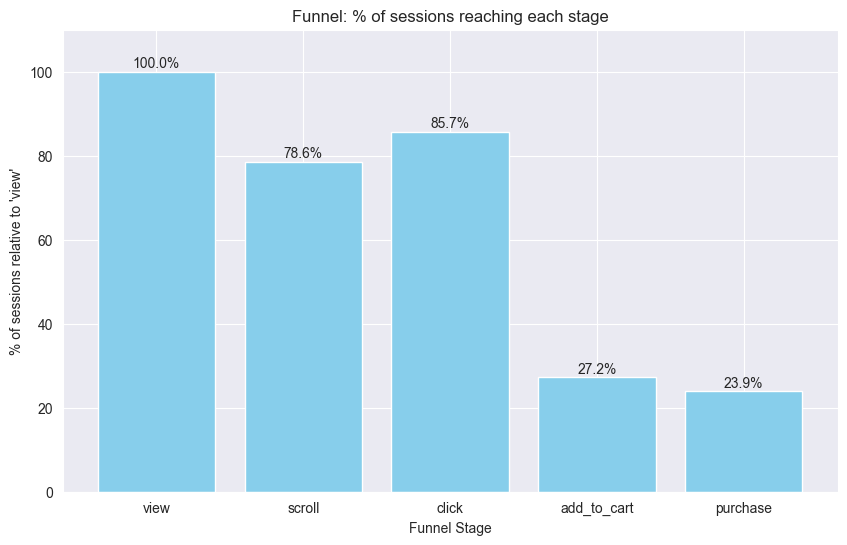

In [29]:
# step-by-step funnel metrics
stages = ['view', 'scroll', 'click', 'add_to_cart', 'purchase']

# Count how many sessions reach each stage
session_stage = pd.DataFrame(
    False,  # default value
    index=df_sorted['session_id'].unique(),
    columns=stages,
    dtype=bool  # explicitly set boolean dtype
)
for session_id, group in df_sorted.groupby('session_id'):
    events = group['event_type'].tolist()
    for stage in stages:
        if stage in events:
            session_stage.loc[session_id, stage] = True


# 3. Compute funnel metrics
funnel_counts = session_stage.sum()
funnel_percent = funnel_counts / funnel_counts.iloc[0] * 100  # relative to initial 'view'

# 4. Compute step-to-step conversion
conversion_rates = []
for i in range(len(stages)-1):
    step = stages[i]
    next_step = stages[i+1]
    conversion = session_stage[session_stage[step]][next_step].sum() / session_stage[step].sum() * 100
    conversion_rates.append(conversion)

# 5. Display funnel metrics
funnel_metrics = pd.DataFrame({
    'stage': stages,
    'sessions_reached': funnel_counts.values,
    'percent_of_initial': funnel_percent.values
})
print(funnel_metrics)

# Step-to-step conversion
for i, conv in enumerate(conversion_rates):
    print(f"% who {stages[i+1]} after {stages[i]}: {conv:.2f}%")

# 6. Plot funnel
plt.figure(figsize=(10,6))
plt.bar(funnel_metrics['stage'], funnel_metrics['percent_of_initial'], color='skyblue')
plt.title("Funnel: % of sessions reaching each stage")
plt.ylabel("% of sessions relative to 'view'")
plt.xlabel("Funnel Stage")
plt.ylim(0, 110)

# Add text labels
for i, val in enumerate(funnel_metrics['percent_of_initial']):
    plt.text(i, val+1, f"{val:.1f}%", ha='center')
plt.show()
